In [1]:
import numpy as np
import tensorflow as tf
import keras
import numpy as np
import os
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import utils
import AAPutils
import pandas as pd
from sklearn import model_selection, metrics, preprocessing
from sklearn.compose import ColumnTransformer
# plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [6]:
df = pd.read_csv('./datasets/diabetes.csv')
df['Clase'] = df['Clase'].astype('category')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2000.0,3.70350,3.306063,0.000,1.000,3.000,6.000,17.00
Glucose,2000.0,121.18250,32.068636,0.000,99.000,117.000,141.000,199.00
BloodPressure,2000.0,69.14550,19.188315,0.000,63.500,72.000,80.000,122.00
SkinThickness,2000.0,20.93500,16.103243,0.000,0.000,23.000,32.000,110.00
Insulin,2000.0,80.25400,111.180534,0.000,0.000,40.000,130.000,744.00
BMI,2000.0,32.19300,8.149901,0.000,27.375,32.300,36.800,80.60
DiabetesPedigreeFunction,2000.0,0.47093,0.323553,0.078,0.244,0.376,0.624,2.42
Age,2000.0,33.09050,11.786423,21.000,24.000,29.000,40.000,81.00


In [11]:
df.Clase.value_counts().to_frame()

,Clase
0,1316
1,684


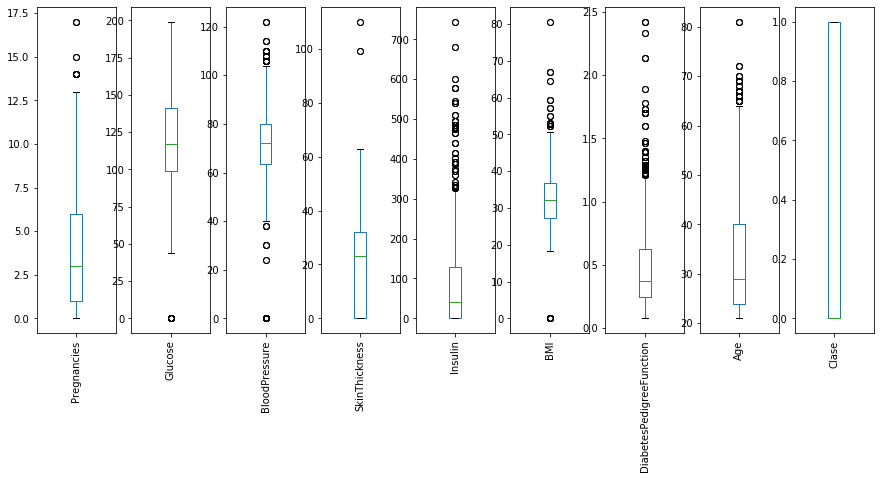

In [3]:
_ = df.plot.box(subplots=True, rot=90, figsize=(15,6))

In [18]:
X = df.loc[:,~df.columns.isin(['Clase'])].values
y = preprocessing.LabelEncoder().fit_transform(df['Clase'].values)

In [185]:
# solo ejecutar cuando se quiere normalizar
ct = ColumnTransformer([
    ("stand0", preprocessing.StandardScaler(), [0]),
    ("stand1", preprocessing.StandardScaler(), [1]),
    ("stand2", preprocessing.StandardScaler(), [2]),
    ("stand3", preprocessing.StandardScaler(), [3]),
    ("stand4", preprocessing.StandardScaler(), [4]),
    ("stand5", preprocessing.StandardScaler(), [5]),
    ("stand6", preprocessing.StandardScaler(), [6]),
    ("stand7", preprocessing.StandardScaler(), [7]),
])

X = ct.fit_transform(X)

In [186]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=7, stratify = y)

In [187]:
d_in = X.shape[1]
d_out = np.unique(y).size
classes = d_out

In [188]:
# verificamos los valores
d_in, d_out, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

(8, 2, (1400, 8), (1400,), (600, 8), (600,))

In [189]:
# y_test.reshape(-1,1)
utils.calculate_class_weight(y_train), utils.calculate_class_weight(y_test), 

({0: 0.6578571428571428, 1: 0.34214285714285714},
 {0: 0.6583333333333333, 1: 0.3416666666666667})

In [190]:
weight = {
   0: 0.6, 1: 0.4
}

In [191]:
layers = []

layer1 = keras.layers.Dense(
    180, 
    input_shape=(d_in,), 
    activation='relu'
)
layers.append(layer1)


layer2 = keras.layers.Dense(
    100, 
    activation='relu'
)
layers.append(layer2)


layers.append(
    keras.layers.Dense(
    60, 
    activation='relu'
))

# layers.append(keras.layers.Dense(
#     10, 
#     activation='relu'
# ))

# layers.append(keras.layers.Dense(
#     10, 
#     activation='relu'
# ))


# https://en.wikipedia.org/wiki/Logit
# la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
output = keras.layers.Dense(classes, activation='softmax')
layers.append(output)

# Creo un modelo logístico
model = keras.Sequential()

for l in layers:
    model.add(l)

# posibles optimizadores:
# https://keras.io/optimizers/

alpha = 0.001
epochs = 1500

model.compile(
  optimizer= 'adam',
  #optimizer = keras.optimizers.SGD(lr=alpha), 
  loss='sparse_categorical_crossentropy', # error para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=[
      'accuracy', 
      #'sparse_categorical_accuracy'
  ], 
)

In [192]:
# Entrenamiento del modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32, 
    verbose=0, 
#     initial_epoch=400,
    callbacks = [
        # https://stackoverflow.com/questions/43906048/keras-early-stopping
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # Early stopping callback is called on every epoch end, compares the best monitored value with the current one and stops if conditions are met
       keras.callbacks.callbacks.EarlyStopping(
           monitor='val_loss', 
#            min_delta=0, 
           patience=50,
           verbose=0, 
           mode='auto', 
#            baseline=0.3, 
           restore_best_weights=True
       )
    ],
    validation_data = (X_test, y_test),
    class_weight = weight # acá va esto? o el de train?
)
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 180)               1620      
_________________________________________________________________
dense_81 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_82 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_83 (Dense)             (None, 2)                 122       
Total params: 25,902
Trainable params: 25,902
Non-trainable params: 0
_________________________________________________________________


In [193]:
print(10*"=")
print("TEST SCORES")
print(metrics.classification_report(y_test, model.predict_classes(X_test)))
print(model.metrics_names)
print(model.evaluate(X_test, y_test))
print(10*"=")
print("TRAIN SCORES")
print(metrics.classification_report(y_train, model.predict_classes(X_train)))
print(model.metrics_names)
print(model.evaluate(X_train, y_train))

TEST SCORES
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       395
           1       0.92      0.89      0.91       205

    accuracy                           0.94       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.94      0.94      0.94       600

['loss', 'accuracy']
600/600 [==============================] - 0s 53us/step
[0.19566500306129456, 0.9383333325386047]
TRAIN SCORES
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       921
           1       1.00      0.97      0.98       479

    accuracy                           0.99      1400
   macro avg       0.99      0.98      0.99      1400
weighted avg       0.99      0.99      0.99      1400

['loss', 'accuracy']
1400/1400 [==============================] - 0s 48us/step
[0.04591268281851496, 0.9892857074737549]


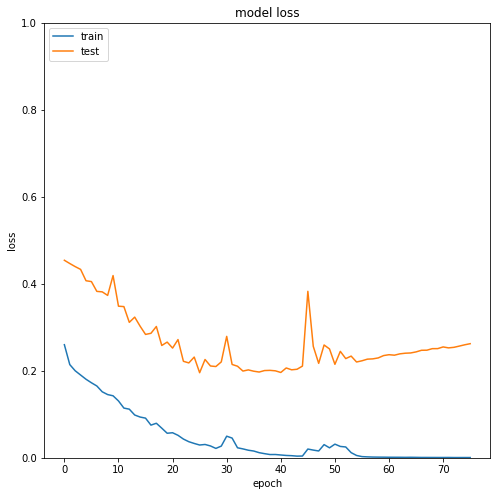

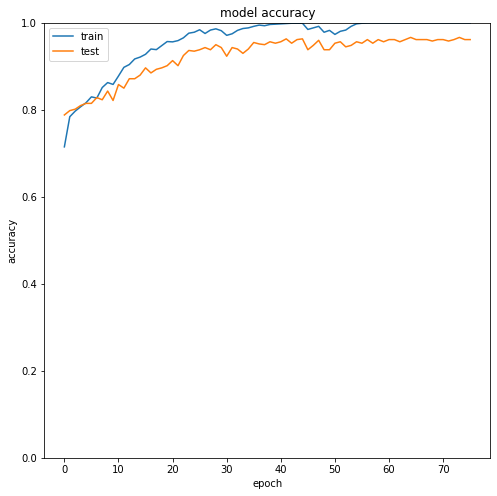

In [194]:
for k, i in zip(list(range(len(model.metrics_names))), model.metrics_names):
    plt.figure(figsize=(8,8))
    plt.ylim(0,1)
    utils.plot_curve(history, i)

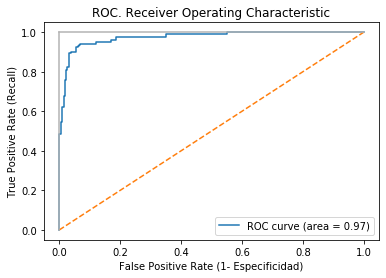

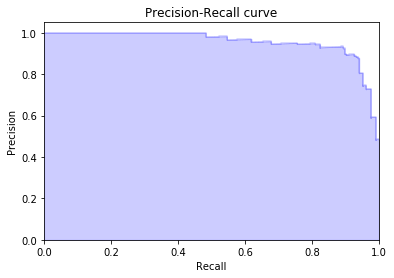

In [195]:
AAPutils.plot_ROC_curve(model, X_test, y_test)

In [184]:
print(metrics.confusion_matrix(y_test, model.predict_classes(X_test)))

[[377  18]
 [ 16 189]]


## Conclusiones
Hicimos train_test_split de manera "stratify".

___
### 1 capa

Con una capa 1 de 20 neuronas alpha 0.001 y 1500 epochs, se ven pocas mejoras. 0.73 de F1, se ve mucho ruido en learning curve y acc . Si cambiamos la función de optimización por "adam" se ve semejante, pero mejora un poco la performance. 0.81 acc.

Agregamos más neuronas a la capa (100) con el modelo en 1500 epochs (frena en 250 epochs). Se ve que sigue oscilando mucho en learning curve (loss) de testing. (Roc de 0.88). No alcanzamos overfitting. 

Agregamos más neuronas (150) modelo en 1500 epochs (frena en 300). en acc con .88 en train y .82 en test. Parece un poco overfitteado ya. 

Agregamos más neuronas (180) modelo se detiene en 350. en acc en train .89 y en test .87

____
### 2 capas
agregamos una capa al modelo con 10 neuronas. Se detiene en 350. train .90 y test .87 de acc. El loss sigue bastante separado (0.34 para test y 0.22 para test).

agregamos más neuronas (60). Se detiene en 350. ACC train .90 y test .87 . El loss sigue bastante separado (0.35 para test y 0.23 para test). 

agregamos más neuronas (100). Se detiene en 350. train .96 y test .91 de f1. El loss sigue bastante separado (0.27 para test y 0.12 para test). ROC bueno (0.97) (probamos con 120 y empeoró un poco)

______
### 3 capas
con una nueva capa de 10 neuronas tiene peor performance. se detuvo en 250. ACC de train .91 y test 0.85. roc 0.93

con una capa de 60 neuronas se detuvo en 300. acc train .99 y .94 de test. roc 0.98. LOSS 0.05 y 0.23

Si tocamos los weights (entiendo que es lo mismo que mover el threshold).   
    
    
- si pongo más peso a 0 ( 0.75 en 0 )
    -      precision    recall  f1-score
    - 0       0.92      0.94      0.93       
    - 1       0.88      0.85      0.87       

- si pongo más peso a 1 ( n en 0.6 ) 
    
    - 0       0.93      0.98      0.95
    - 1       0.96      0.86      0.90
- si pongo el peso real ( 0.65 en 0 )
    
    - 0       0.91      0.97      0.94      
    - 1       0.94      0.81      0.87

nota: Cuando digo "más peso" es un poco más que el porcentaje real.

El mismo modelo normalizado (con la distribución de pesos 0.6-0.4, entrena mucho más rápido; en 70 epocas el modelo detecta el mismo patrón aproximado
- 0       0.95      0.96      0.95       
- 1       0.92      0.89      0.91       
- accuracy  0.94

Esto es bueno porque nos permitiría probar con capas más anchas o profundas!.  
Es más, terminamos cambiado el "patience", porque overfittea en 60 epochs. 